In [1]:
!pip install gym==0.17.3
!pip install matplotlib
!pip install tensorflow==2.10

In [2]:
import gym
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
from collections import deque
import os

In [3]:
class DQN:
    def __init__(self,
                 InputShape,
                 NActions,
                 Gamma,
                 ReplayMemorySize,
                 MinReplayMemory,
                 UpdateTargetEveryThisEpisodes,
                 IntermediateSize ,
                 BatchSize):

        # Hyperparameters. #

        self.InputShape = InputShape
        self.NActions = NActions
        self.Gamma = Gamma
        self.ReplayMemorySize = ReplayMemorySize
        self.MinReplayMemory = MinReplayMemory
        self.UpdateTargetEveryThisEpisodes = UpdateTargetEveryThisEpisodes
        self.IntermediateSize = IntermediateSize
        self.BatchSize = BatchSize

        # Main model. #

        self.Main = self.CreateModel('Main')
        self.Optimiser = Adam()

        # Target model. #

        self.Target = self.CreateModel('Target')
        self.Target.set_weights(self.Main.get_weights())

        # Replay memory. #

        self.ReplayMemory = deque(maxlen = ReplayMemorySize)

        # Target network update counter. #

        self.TargetUpdateCounter = 0

    # new: track all batch‐losses, and per‐episode averages
        self.loss_history = []                # flat list of every batch loss
        self.episode_loss_averages = []       # one float per episode

    def CreateModel(self, Type):
        inputs = Input(shape = (self.InputShape), name = 'Input')
        x = Dense(self.IntermediateSize, activation = 'relu', name = '1stHiddenLayer')(inputs)
        x = Dense(self.IntermediateSize, activation = 'relu', name = '2ndHiddenLayer')(x)
        outputs = Dense(self.NActions, activation = 'linear', name = 'Output')(x)

        NN = Model(inputs, outputs, name = f'{Type}')
        NN.summary()

        return NN

    def UpdateReplayMemory(self, Information): # Information = (S, A, R, SNext, Done)
        self.ReplayMemory.append(Information)

    def Train(self, EndOfEpisode):

        # Only train if replay memory has enough data. #

        if len(self.ReplayMemory) < self.MinReplayMemory:
            print(f'DID NOT TRAIN..., replay memory = {len(self.ReplayMemory)}')
            return

        # Get batch of data for training. #

        TrainingData = random.sample(self.ReplayMemory, self.BatchSize)

        # Get states from training data, then get corresponding Q values. #

        ListOfS = np.array([element[0] for element in TrainingData])
        ListOfQ = np.array(self.Main(ListOfS))

        # Get future states from training data, then get corresponding Q values. #

        ListOfSNext = np.array([element[3] for element in TrainingData])
        ListOfQNext = self.Target(ListOfSNext)

        # Build actual training data for neural network. #

        X = []
        Y = []
        for index, (S, A, R, SNext, Done) in enumerate(TrainingData):
            if not Done:
                MaxQNext = np.max(ListOfQNext[index])
                QNext = R + self.Gamma * MaxQNext
            else:
                QNext = R
            Q = ListOfQ[index]
            Q[A] = QNext

            X.append(S)
            Y.append(Q)

        # Train model using tf.GradientTape(), defined below.

        #self.GTfit(X, Y)

        # — do one gradient step and record its loss —
        loss_tensor = self.GTfit(X, Y)
        self.loss_history.append(float(loss_tensor))

        # Update target network every episode. #

        if EndOfEpisode:
            self.TargetUpdateCounter += 1

        # Update target if counter is full. #

        if self.TargetUpdateCounter >= self.UpdateTargetEveryThisEpisodes:
            self.Target.set_weights(self.Main.get_weights())
            self.TargetUpdateCounter = 0

    # This is the tf.GradientTape() which significantly speeds up training of neural networks.

    @tf.function
    def GTfit(self, X, Y):
        X_tensor = tf.convert_to_tensor(X)
        Y_tensor = tf.convert_to_tensor(Y)
        # Train the neural network with this batch of data. #

        with tf.GradientTape() as tape:
            Predictions = self.Main(tf.convert_to_tensor(X), training = True)
            loss = tf.math.reduce_mean(tf.math.square(tf.convert_to_tensor(Y) - Predictions))
        Grad = tape.gradient(loss, self.Main.trainable_variables)
        self.Optimiser.apply_gradients(zip(Grad, self.Main.trainable_variables))
        return loss

In [4]:
#params that doesnt change
env = gym.make('Pendulum-v0')

statesize=env.observation_space.shape[0]

numaction=21
action_bins = np.linspace(-2, 2, numaction)
print(action_bins)


EpsilonMin   = 0.01

Epsilon = 1.0
ShowEvery = 10



[-2.  -1.8 -1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6
  0.8  1.   1.2  1.4  1.6  1.8  2. ]


In [5]:
EpsilonDecay = 0.995

base_agent = DQN(
    InputShape=statesize,
    NActions=numaction,
    Gamma=0.99,
    ReplayMemorySize=100000,
    MinReplayMemory=320,
    UpdateTargetEveryThisEpisodes=ShowEvery,
    IntermediateSize=64,
    BatchSize=64
)


Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 21)                1365      
                                                                 
Total params: 5,781
Trainable params: 5,781
Non-trainable params: 0
_________________________________________________________________
Model: "Target"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]    

In [ ]:
def PendulumActionConverter(A, NActions=numaction):
    ActualTorque = (A / NActions - 0.5) * 4
    return ActualTorque

def PendulumInverseActionConverter(A, NActions=numaction):
    ActualA = round((A + 2) * (NActions - 1) / 4)
    return(ActualA)
'''
def OneEpisode():

    S = env.reset()
    ListOfRewards = []
    Done = False
    while not Done:
        Q = DQN.Main(S.reshape(-1, S.shape[0]))
        if np.random.rand() < Epsilon:
            AStep = env.action_space.sample()
            A = PendulumInverseActionConverter(AStep[0])
        else:
            A = np.argmax(Q)
            A = PendulumActionConverter(A)
            AStep = np.array([A])
            A = PendulumInverseActionConverter(A)
        if not _ % ShowEvery and len(DQN.ReplayMemory) >= DQN.MinReplayMemory:
            env.render()
        SNext, R, Done, Info = env.step(AStep)
        DQN.UpdateReplayMemory((S, A, R, SNext, Done))
        DQN.Train(Done)
        ListOfRewards.append(R)
        if Done:
            print(f'Finished! Return: {np.sum(ListOfRewards)}')
            env.close()
            return
        S = SNext'''
def OneEpisode(agent, env, action_bins):
    S = env.reset()
    Done = False
    total_reward = 0

    while not Done:
        # 1) get Q-values from *this* agent
        q_vals = agent.Main(S.reshape(1, -1), training=False).numpy()[0]

        # 2) ε-greedy
        if np.random.rand() < Epsilon:
            A = np.random.randint(0, agent.NActions)#A = env.action_space.sample()
        else:
            A = np.argmax(q_vals)

        # 3) step
        SNext, R, Done, _ = env.step([action_bins[A]])
        total_reward += R

        try: env.render()
        except: pass
        
        # 4) store & train
        agent.UpdateReplayMemory((S, A, R, SNext, Done))
        agent.Train(EndOfEpisode=False)

        S = SNext

    # 5) at episode end, do one more Train() with EndOfEpisode=True
    agent.Train(EndOfEpisode=True)

    return total_reward


In [7]:
import time

def train_agent(base_agent, env, action_bins, episodes=500):
    

    STARTTIME = time.time()

    reward_history = []
    epsilon_history = []

    Epsilon = 1.0  # assume starting epsilon here; adjust if needed
    EpsilonDecay = 0.990
    EpsilonMin = 0.01

    for ep in range(episodes):
        ep_start = time.time()

        # track where this episode’s losses begin
        start_idx = len(base_agent.loss_history)

        # run one episode
        total_reward = OneEpisode(base_agent, env, action_bins)
        reward_history.append(total_reward)

        # decay epsilon
        Epsilon = max(EpsilonMin, Epsilon * EpsilonDecay)
        epsilon_history.append(Epsilon)

        # episode-level loss average
        ep_losses = base_agent.loss_history[start_idx:]
        ep_loss = sum(ep_losses) / len(ep_losses) if ep_losses else 0.0

        # reward stats
        avg_reward = sum(reward_history) / len(reward_history)
        last20_avg_reward = sum(reward_history[-20:]) / len(reward_history[-20:])

        # duration
        ep_time = time.time() - ep_start

        print(
            f"Episode {ep+1:3d} | "
            f"Time: {ep_time:5.2f}s | "
            f"Reward: {total_reward:7.2f} | "
            f"AvgReward: {avg_reward:7.2f} | "
            f"Last20AvgReward: {last20_avg_reward:7.2f} | "
            f"Loss: {ep_loss:.4f} | "
            f"ε: {Epsilon:.4f}"
        )

    print(f"\nTotal time taken: {time.time() - STARTTIME:.2f}s")

    return reward_history, epsilon_history

In [8]:
reward_history, epsilon_history = train_agent(base_agent, env, action_bins, episodes=500)


DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory = 26
DID NOT TRAIN..., replay memory = 27
DID NOT TR

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_episode_rewards(reward_history):
    plt.figure(figsize=(10, 4))
    plt.plot(reward_history, label='Episode Reward')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Episode Reward over Time')
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_moving_avg(reward_history, window=20):
    moving_avg = np.convolve(reward_history, np.ones(window)/window, mode='valid')
    plt.figure(figsize=(10, 4))
    plt.plot(moving_avg, label=f'Moving Avg (window={window})', color='orange')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.title(f'Moving Average Reward (Last {window} Episodes)')
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_epsilon(epsilon_history):
    if epsilon_history is not None and len(epsilon_history) > 0:
        plt.figure(figsize=(10, 4))
        plt.plot(epsilon_history, label='Epsilon', color='green')
        plt.xlabel('Episode')
        plt.ylabel('Epsilon')
        plt.title('Epsilon Decay Over Time')
        plt.grid(True)
        plt.legend()
        plt.show()
    else:
        print("No epsilon history to plot.")

def plot_loss(loss_history):
    plt.figure(figsize=(10, 4))
    plt.plot(loss_history, label='Loss', color='red')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.title('Loss per Episode')
    plt.grid(True)
    plt.legend()
    plt.show()


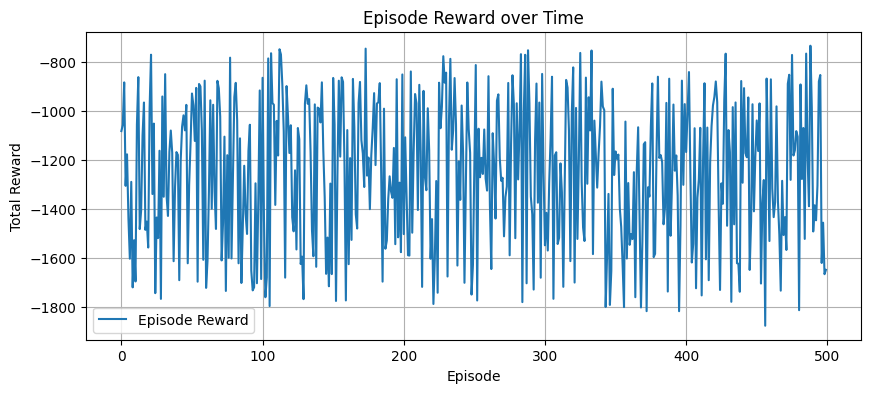

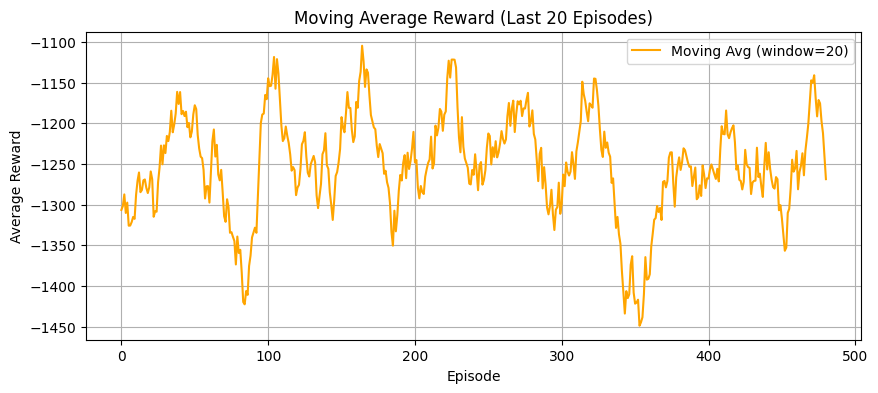

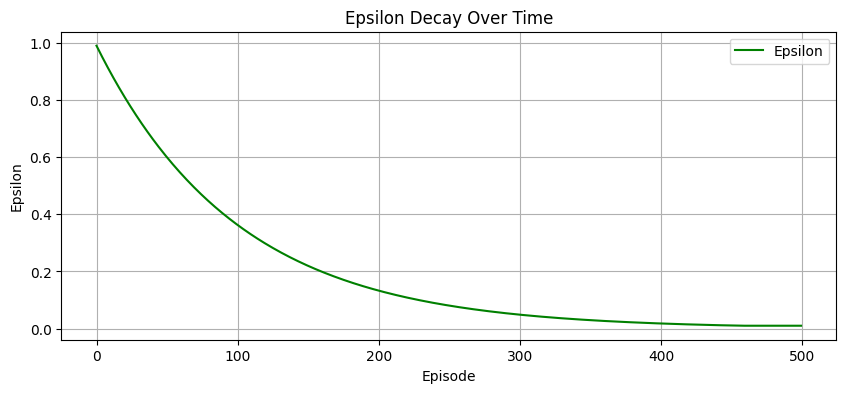

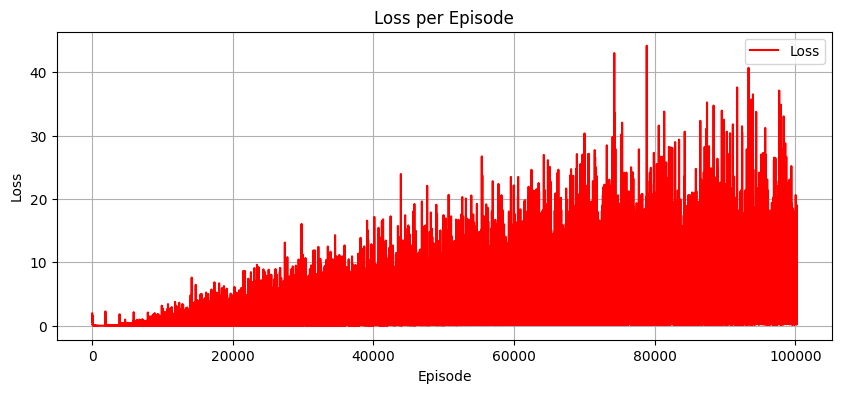

In [10]:
plot_episode_rewards(reward_history)
plot_moving_avg(reward_history, window=20)
plot_epsilon(epsilon_history) 
plot_loss(base_agent.loss_history)